In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import numpy as np
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
random.seed(100)
import pandas as pd
import numpy as np

from joblib import dump, load
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)
from scipy import ndimage
from scipy import signal
from scipy import stats
import skimage.color
import skimage.exposure
import skimage.io
import skimage.util
import xgboost as xgb
from tqdm import tqdm

from sklearn.model_selection import ParameterGrid
from gensim.models import Word2Vec

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, f1_score, precision_score

from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")


## 1 Load our Dataset

In [2]:
csv_path = 'combined_dataset.csv'

column_names = ['epitope', 'CDR3', 'binding']

# 读取csv文件，使用列名参数
df = pd.read_csv(csv_path, sep=',', names=column_names)

print(df.head())

      epitope                CDR3  binding
0  EAAGIGILTV          CASSLGNEQF        1
1  EAAGIGILTV       CASSLGVATGELF        1
2  EAAGIGILTV  CASSQEEGGGSWGNTIYF        1
3  EAAGIGILTV     CASSQEGLAGASQYF        1
4  EAAGIGILTV   CASSQETDIVFNOPQHF        1


In [3]:
print(df.describe())
print()
print(df["binding"].value_counts())

             binding
count  256284.000000
mean        0.500000
std         0.500001
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000

binding
1    128142
0    128142
Name: count, dtype: int64


In [4]:
# split epitopes
epitopes_of_interest = ['GLCTLVAML', 'GILGFVFTL', 'NLVPMVATV']

df = df[df['epitope'].isin(epitopes_of_interest)]
df.reindex()
print(df.info())
print(df["binding"].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 36088 entries, 30 to 256282
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   epitope  36088 non-null  object
 1   CDR3     36088 non-null  object
 2   binding  36088 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
None
binding
1    18044
0    18044
Name: count, dtype: int64


## 2. Preprocess and Feature Representation

In this dataset, the epitope sequences are our features ($X$), and the `binding` is our predictive goal ($y$). 

Let's start by reading data.

In [5]:
# load Epitope sequences & complementarity determining region 3
df = df.dropna()
epitope_sequences = df['epitope'].values
CDR3 = df['CDR3'].values

# load target
y = df['binding'].values

print("====== Epitope Sequences ======")
print(f"The type of epitope_sequences: {epitope_sequences.dtype}")
print(len(epitope_sequences))
print("====== Complementarity Determining Region 3 ======")
print(len(CDR3))
print(f"The type of CDR3: {CDR3.dtype}")
print("====== Target (y) ======")
print(f"The type of y: {y.dtype}")
print(f"The shape of y: {y.shape}")

====== Epitope Sequences ======
The type of epitope_sequences: object
36088
====== Complementarity Determining Region 3 ======
36088
The type of CDR3: object
====== Target (y) ======
The type of y: int64
The shape of y: (36088,)


### 2.1 Preprocess: Epitope sequences

Each capital letter in the Epitope sequence represents an amino acid. There are 20 naturally occurring amino acids, so in general, there are 20 capital letters that make up the Epitope sequence. 

Let's remove sequences with unnatural amino acids and verify that the Epitopes in the dataset are all made up of natural amino acids, and look at the lengths of these sequences.

In [6]:
lengths = set()
letters = set()

for seq in epitope_sequences:
    lengths.add(len(seq))
    letters.update(seq)
print("Epitope Sequences:")
print(f"Lengths: {lengths}")
print(f"Letters: {letters}")


lengths = set()
letters = set()

for seq in CDR3:
    lengths.add(len(seq))
    letters.update(seq)
print("Complementarity Determining Region 3 :")
print(f"Lengths: {lengths}")
print(f"Letters: {letters}")

Epitope Sequences:
Lengths: {9}
Letters: {'A', 'G', 'T', 'P', 'F', 'M', 'N', 'I', 'V', 'C', 'L'}
Complementarity Determining Region 3 :
Lengths: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 31, 32, 36}
Letters: {'y', 'B', 'D', 'I', 'f', 'E', 'T', 'S', 'V', 'L', 'H', 'K', 'P', 'M', 'Y', 'W', 'A', 'Q', 'G', 'F', 'N', 'R', 'C'}


In [7]:
# prededfined 20 nature amino acids
amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
# create a set for faster lookup
amino_acids_set = set(amino_acids)

# filter the sequences
filtered_sequences = []
filtered_CDR3 = []
filtered_y = []

for i, seq in enumerate(epitope_sequences):
    if set(seq).issubset(amino_acids_set) and set(CDR3[i]).issubset(amino_acids_set):
        filtered_sequences.append(seq)
        filtered_y.append(y[i])
        filtered_CDR3.append(CDR3[i])

# for i, seq in enumerate(CDR3):
#     if set(seq).issubset(amino_acids_set):
#         filtered_CDR3.append(seq)



epitope_sequences = filtered_sequences
CDR3 = filtered_CDR3
y = np.array(filtered_y)

# verify
lengths = set()
letters = set()

for seq in epitope_sequences:
    lengths.add(len(seq))
    letters.update(seq)
print("Epitope Sequences:")
print(f"Lengths: {lengths}")
print(f"Letters: {letters}")


lengths = set()
letters = set()

for seq in CDR3:
    lengths.add(len(seq))
    letters.update(seq)

    
print("Complementarity Determining Region 3 :")
print(f"Lengths: {lengths}")
print(f"Letters: {letters}")

print("====== Epitope Sequences ======")
# print(f"The type of epitope_sequences: {epitope_sequences.type}")
print(f"The shape of epitope_sequences: {len(epitope_sequences)}")
print("====== Complementarity Determining Region 3  ======")
# print(f"The type of epitope_sequences: {epitope_sequences.type}")
print(f"The shape of CDR3: {len(CDR3)}")
print("====== Target (y) ======")
print(f"The type of y: {y.dtype}")
print(f"The shape of y: {y.shape}")

Epitope Sequences:
Lengths: {9}
Letters: {'A', 'G', 'T', 'P', 'F', 'M', 'N', 'I', 'V', 'C', 'L'}
Complementarity Determining Region 3 :
Lengths: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 31, 32, 36}
Letters: {'D', 'I', 'E', 'T', 'S', 'V', 'L', 'H', 'K', 'P', 'M', 'Y', 'W', 'A', 'Q', 'G', 'F', 'N', 'R', 'C'}
====== Epitope Sequences ======
The shape of epitope_sequences: 36084
====== Complementarity Determining Region 3  ======
The shape of CDR3: 36084
====== Target (y) ======
The type of y: int64
The shape of y: (36084,)


We can see that these Epitopes range in length from 9 to 20, and the filtered sequences are all made up of 20 different natural amino acids. 

How can we map these amino acids to arrays? One simple way is to do one-hot coding.

#### 2.1.1 One-Hot Encoding

The one-hot encoding can map the Epitope sequence to a sparse vector of length 20. 

For these 20 amino acids, if they are present in the Epitope sequence, they have a value of 1 in the vector, and 0 otherwise.

![one-hot](imgs/one_hot.jpg)

**Fig 2.1** One-hot Encoding

In [8]:
# prededfined 20 nature amino acids
amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
# create a dictionary for amino acids
aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}

# one-hot encoding, convert each Epitope sequence to a sparse vector of length 20
def one_hot_encode(original_sequence):
    one_hot_array = []
    for sequence in original_sequence:
        one_hot = np.zeros(len(amino_acids)) # default 0
        for i, aa in enumerate(sequence):
            if aa in aa_to_index: # if the animo acid is one of 20 nature amino acids
                one_hot[aa_to_index[aa]] = 1.0 # set the value to 1
        one_hot_array.append(one_hot)
    return np.array(one_hot_array)

Epitope_one_hot = one_hot_encode(epitope_sequences)
CDR3_one_hot = one_hot_encode(CDR3)
print(f"[Shape] One-hot encoding of epitope_sequences: {Epitope_one_hot.shape}")
print(f"[Shape] One-hot encoding of CDR3: {CDR3_one_hot.shape}")

[Shape] One-hot encoding of epitope_sequences: (36084, 20)
[Shape] One-hot encoding of CDR3: (36084, 20)


We can see that these Epitopes range in length from 9 to 20, and the filtered sequences are all made up of 20 different natural amino acids. 

How can we map these amino acids to arrays? One simple way is to do one-hot coding.

#### 2.1.1 One-Hot Encoding

The one-hot encoding can map the Epitope sequence to a sparse vector of length 20. 

For these 20 amino acids, if they are present in the Epitope sequence, they have a value of 1 in the vector, and 0 otherwise.

![one-hot](imgs/one_hot.jpg)

**Fig 2.1** One-hot Encoding

In [9]:
# prededfined 20 nature amino acids
amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
# create a dictionary for amino acids
aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}

# one-hot encoding, convert each epitope sequence to a sparse vector of length 20
def one_hot_encode(original_sequence):
    one_hot_array = []
    for sequence in original_sequence:
        one_hot = np.zeros(len(amino_acids)) # default 0
        for i, aa in enumerate(sequence):
            if aa in aa_to_index: # if the animo acid is one of 20 nature amino acids
                one_hot[aa_to_index[aa]] = 1.0 # set the value to 1
        one_hot_array.append(one_hot)
    return np.array(one_hot_array)

epitope_one_hot = one_hot_encode(epitope_sequences)
CDR3_one_hot = one_hot_encode(CDR3)
print(f"[Shape] One-hot encoding of epitope_sequences: {epitope_one_hot.shape}")
print(f"[Shape] One-hot encoding of CDR3: {CDR3_one_hot.shape}")

[Shape] One-hot encoding of epitope_sequences: (36084, 20)
[Shape] One-hot encoding of CDR3: (36084, 20)


One-hot coding is simple and straightforward. Considering that the amino acid sequence of a epitope is essentially a string, we can treat them as text and map them to vectors using word embeddings, such as word2vec[1].

#### 2.1.2 Word2Vec Embedding

For epitope sequences, we can treat each amino acid as a word to train a word2vec model.

![word2vec](imgs/word2vec.jpg)

**Fig 2.2** Word2Vec

Reference:

[1] Le, Quoc, and Tomas Mikolov. "Distributed representations of sentences and documents." International conference on machine learning. PMLR, 2014.

In [10]:
from gensim.models import Word2Vec

def convert_seq2characters(original_sequence):
    # Convert each epitope sequence into a list of characters, 
    #   i.e., treat each amino acid as a word
    sequences = [list(seq) for seq in original_sequence]

    # train a word2vec model
    model = Word2Vec(sequences, min_count=1, vector_size=20)

    seq_word2vec = []
    # Build word2Vec features
    for sentence in sequences:
        sentence_vector = []
        for word in sentence:
            # if the word is in the wv list
            if word in model.wv:
                word_vec = model.wv[word]
                sentence_vector.append(word_vec)
        if len(sentence_vector) > 0:
            # can be presented as a vector
            average_vec = np.mean(sentence_vector,axis=0)
        else:
            # vector of 0 as default
            average_vec = np.zeros(20)
        seq_word2vec.append(average_vec)

    seq_word2vec = np.array(seq_word2vec)
    return seq_word2vec

epitope_word2vec = convert_seq2characters(epitope_sequences)
CDR3_word2vec = convert_seq2characters(CDR3)

print(f"[Shape] Word2Vec encoding of epitope_sequences: {epitope_word2vec.shape}")
print(f"[Shape] Word2Vec encoding of CDR3: {CDR3_word2vec.shape}")

[Shape] Word2Vec encoding of epitope_sequences: (36084, 20)
[Shape] Word2Vec encoding of CDR3: (36084, 20)


#### 2.1.3 Atchley Factor Mapping

For both One-hot coding and Word2Vec embedding, they do not take into account the physicochemical properties of amino acids. In 2005, Atchley et al.[2] proposed a method to encode amino acids using five physicochemical properties. Therefore, we can utilize the Atchley factors to encode our epitope sequences.

In order to generate uniformly shaped embedding, we need to add pads to the amino acid sequences to unify them into strings of length 15 (maximum length).

![padding](imgs/padding.jpg)

**Fig 2.3** Padding a AA Sequence

Here, we refer to Luu et al.[3] for characters that are padded. For padded characters, we set the default values of all their physicochemical properties to 0.5 ; in addition, a dimension is added to the 5 dimensions of the Atchley Factor for labeling whether this vector is an amino acid (1) or a pad (0).

![atchley](imgs/atchley.jpg)

**Fig 2.4** Atchley Factor Mapping

We obtained the predefined Atchley Factor dictionary from the project of Luu et al. The link to the project is as follows: [TCR-Epitope-Binding](https://github.com/jssong-lab/TCR-Epitope-Binding).

References:

[2] Atchley, William R., et al. "Solving the protein sequence metric problem." Proceedings of the National Academy of Sciences 102.18 (2005): 6395-6400.

[3] Luu, Alan M et al. “Predicting TCR-Epitope Binding Specificity Using Deep Metric Learning and Multimodal Learning.” Genes vol. 12,4 572. 15 Apr. 2021, doi:10.3390/genes12040572

In [11]:
import pickle as pk

aa_vec = pk.load(open('atchley.pk', 'rb'))

def atchley_encode(sequences, length, pad=True, dict = aa_vec):
    if pad:
        sequences = [seq.ljust(length, ' ') for seq in sequences]
    encoded_sequences = np.empty((len(sequences), length , 6))
    for i, sequence in enumerate(sequences):
        for j, char in enumerate(sequence):
            encoded_sequences[i, j] = dict[char]
    return encoded_sequences

epitope_atchley = atchley_encode(epitope_sequences, length=9, pad=True, dict = aa_vec)
CDR3_atchley = atchley_encode(CDR3, length=36, pad=True, dict = aa_vec)

print(f"[Shape] epitope_sequences Atchley Factor Mapping: {epitope_atchley.shape}")
print(f"[Shape] CDR3 Atchley Factor Mapping: {CDR3_atchley.shape}")



[Shape] epitope_sequences Atchley Factor Mapping: (36084, 9, 6)
[Shape] CDR3 Atchley Factor Mapping: (36084, 36, 6)


#### 2.1.4 Blosum Matrix

The BLOcks SUBstitution (BLOSUM) Matrix [4] can also be used to represent amino acid sequences. Each number in the BLOSUM matrix represents the similarity of the current amino acid to another. A positive value indicates that two amino acids are replaced more often than randomly, and a negative value indicates the opposite.

The number $n$ after BLOSUM, represents the substitution matrix constructed using a local sequence comparison similarity of at least $n%$ of the Block. 

![blosum](imgs/blosum_matrix.jpg)

**Fig 2.5** Blosum 62 Matrix

We chose the commonly used BLOSUM50 and BLOSUM62 to encode our epitope sequences. We represent each amino acid in the epitope sequence, according to the BLOSUM matrix, as a 20-dimensional vector representing the similarity of the current amino acid to other amino acids.

![blosum_encoded](imgs/blosum_encoded.jpg)

**Fig 2.6** Blosum mapping

In [12]:
# Predefined blosum 50 and blosum 62 matrix
blosum50 = {
    'A': np.array((5, -2, -1, -2, -1, -1, -1, 0, -2, -1, -2, -1, -1, -3, -1, 1, 0, -3, -2, 0)),
    'R': np.array((-2, 7, -1, -2, -4, 1, 0, -3, 0, -4, -3, 3, -2, -3, -3, -1, -1, -3, -1, -3)),
    'N': np.array((-1, -1, 7, 2, -2, 0, 0, 0, 1, -3, -4, 0, -2, -4, -2, 1, 0, -4, -2, -3)),
    'D': np.array((-2, -2, 2, 8, -4, 0, 2, -1, -1, -4, -4, -1, -4, -5, -1, 0, -1, -5, -3, -4)),
    'C': np.array((-1, -4, -2, -4, 13, -3, -3, -3, -3, -2, -2, -3, -2, -2, -4, -1, -1, -5, -3, -1)),
    'Q': np.array((-1, 1, 0, 0, -3, 7, 2, -2, 1, -3, -2, 2, 0, -4, -1, 0, -1, -1, -1, -3)),
    'E': np.array((-1, 0, 0, 2, -3, 2, 6, -3, 0, -4, -3, 1, -2, -3, -1, -1, -1, -3, -2, -3)),
    'G': np.array((0, -3, 0, -1, -3, -2, -3, 8, -2, -4, -4, -2, -3, -4, -2, 0, -2, -3, -3, -4)),
    'H': np.array((-2, 0, 1, -1, -3, 1, 0, -2, 10, -4, -3, 0, -1, -1, -2, -1, -2, -3, 2, -4)),
    'I': np.array((-1, -4, -3, -4, -2, -3, -4, -4, -4, 5, 2, -3, 2, 0, -3, -3, -1, -3, -1, 4)),
    'L': np.array((-2, -3, -4, -4, -2, -2, -3, -4, -3, 2, 5, -3, 3, 1, -4, -3, -1, -2, -1, 1)),
    'K': np.array((-1, 3, 0, -1, -3, 2, 1, -2, 0, -3, -3, 6, -2, -4, -1, 0, -1, -3, -2, -3)),
    'M': np.array((-1, -2, -2, -4, -2, 0, -2, -3, -1, 2, 3, -2, 7, 0, -3, -2, -1, -1, 0, 1)),
    'F': np.array((-3, -3, -4, -5, -2, -4, -3, -4, -1, 0, 1, -4, 0, 8, -4, -3, -2, 1, 4, -1)),
    'P': np.array((-1, -3, -2, -1, -4, -1, -1, -2, -2, -3, -4, -1, -3, -4, 10, -1, -1, -4, -3, -3)),
    'S': np.array((1, -1, 1, 0, -1, 0, -1, 0, -1, -3, -3, 0, -2, -3, -1, 5, 2, -4, -2, -2)),
    'T': np.array((0, -1, 0, -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1, 2, 5, -3, -2, 0)),
    'W': np.array((-3, -3, -4, -5, -5, -1, -3, -3, -3, -3, -2, -3, -1, 1, -4, -4, -3, 15, 2, -3)),
    'Y': np.array((-2, -1, -2, -3, -3, -1, -2, -3, 2, -1, -1, -2, 0, 4, -3, -2, -2, 2, 8, -1)),
    'V': np.array((0, -3, -3, -4, -1, -3, -3, -4, -4, 4, 1, -3, 1, -1, -3, -2, 0, -3, -1, 5)),
    ' ': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
}

blosum62 = {
    'A': np.array([4, -1, -2, -2, 0, -1, -1, 0, -2, -1, -1, -1, -1, -2, -1, 1, 0, -3, -2, 0]),
    'R': np.array([-1, 5, 0, -2, -3, 1, 0, -2, 0, -3, -2, 2, -1, -3, -2, -1, -1, -3, -2, -3]),
    'N': np.array([-2, 0, 6, 1, -3, 0, 0, 0, 1, -3, -3, 0, -2, -3, -2, 1, 0, -4, -2, -3]),
    'D': np.array([-2, -2, 1, 6, -3, 0, 2, -1, -1, -3, -4, -1, -3, -3, -1, 0, -1, -4, -3, -3]),
    'C': np.array([0, -3, -3, -3, 9, -3, -4, -3, -3, -1, -1, -3, -1, -2, -3, -1, -1, -2, -2, -1]),
    'Q': np.array([-1, 1, 0, 0, -3, 5, 2, -2, 0, -3, -2, 1, 0, -3, -1, 0, -1, -2, -1, -2]),
    'E': np.array([-1, 0, 0, 2, -4, 2, 5, -2, 0, -3, -3, 1, -2, -3, -1, 0, -1, -3, -2, -2]),
    'G': np.array([0, -2, 0, -1, -3, -2, -2, 6, -2, -4, -4, -2, -3, -3, -2, 0, -2, -2, -3, -3]),
    'H': np.array([-2, 0, 1, -1, -3, 0, 0, -2, 8, -3, -3, -1, -2, -1, -2, -1, -2, -2, 2, -3]),
    'I': np.array([-1, -3, -3, -3, -1, -3, -3, -4, -3, 4, 2, -3, 1, 0, -3, -2, -1, -3, -1, 3]),
    'L': np.array([-1, -2, -3, -4, -1, -2, -3, -4, -3, 2, 4, -2, 2, 0, -3, -2, -1, -2, -1, 1]),
    'K': np.array([-1, 2, 0, -1, -3, 1, 1, -2, -1, -3, -2, 5, -1, -3, -1, 0, -1, -3, -2, -2]),
    'M': np.array([-1, -1, -2, -3, -1, 0, -2, -3, -2, 1, 2, -1, 5, 0, -2, -1, -1, -1, -1, 1]),
    'F': np.array([-2, -3, -3, -3, -2, -3, -3, -3, -1, 0, 0, -3, 0, 6, -4, -2, -2, 1, 3, -1]),
    'P': np.array([-1, -2, -2, -1, -3, -1, -1, -2, -2, -3, -3, -1, -2, -4, 7, -1, -1, -4, -3, -2]),
    'S': np.array([1, -1, 1, 0, -1, 0, 0, 0, -1, -2, -2, 0, -1, -2, -1, 4, 1, -3, -2, -2]),
    'T': np.array([0, -1, 0, -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1, 1, 5, -2, -2, 0]),
    'W': np.array([-3, -3, -4, -4, -2, -2, -3, -2, -2, -3, -2, -3, -1, 1, -4, -3, -2, 11, 2, -3]),
    'Y': np.array([-2, -2, -2, -3, -2, -1, -2, -3, 2, -1, -1, -2, -1, 3, -3, -2, -2, 2, 7, -1]),
    'V': np.array([0, -3, -3, -3, -1, -2, -2, -3, -3, 3, 1, -2, 1, -1, -2, -2, 0, -3, -1, 4]),
    ' ': np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
}

def blosum50_encode(sequences, length, pad=True, dict = aa_vec):
    if pad:
        sequences = [seq.ljust(length, ' ') for seq in sequences]
    encoded_sequences = np.empty((len(sequences), length , 20))
    for i, sequence in enumerate(sequences):
        for j, char in enumerate(sequence):
            encoded_sequences[i, j] = blosum50[char]
    return encoded_sequences

def blosum62_encode(sequences, length, pad=True, dict = aa_vec):
    if pad:
        sequences = [seq.ljust(length, ' ') for seq in sequences]
    encoded_sequences = np.empty((len(sequences), length , 20))
    for i, sequence in enumerate(sequences):
        for j, char in enumerate(sequence):
            encoded_sequences[i, j] = blosum62[char]
    return encoded_sequences

print("====== epitope Sequences ======")
epitope_blosum50 = blosum50_encode(epitope_sequences, length=9, pad=True, dict = aa_vec)
epitope_blosum62 = blosum62_encode(epitope_sequences, length=9, pad=True, dict = aa_vec)
print(f"[Shape] Blosum 50 Mapping: {epitope_blosum50.shape}")
print(f"[Shape] Blosum 62 Mapping: {epitope_blosum62.shape}")

print("====== Complementarity Determining Region 3 ======")
CDR3_blosum50 = blosum50_encode(CDR3, length=36, pad=True, dict = aa_vec)
CDR3_blosum62 = blosum62_encode(CDR3, length=36, pad=True, dict = aa_vec)
print(f"[Shape] Blosum 50 Mapping: {CDR3_blosum50.shape}")
print(f"[Shape] Blosum 62 Mapping: {CDR3_blosum62.shape}")

====== epitope Sequences ======
[Shape] Blosum 50 Mapping: (36084, 9, 20)
[Shape] Blosum 62 Mapping: (36084, 9, 20)
====== Complementarity Determining Region 3 ======
[Shape] Blosum 50 Mapping: (36084, 36, 20)
[Shape] Blosum 62 Mapping: (36084, 36, 20)


To facilitate subsequent training, we reshape the features of each sequence into a one-dimensional vector.

In [13]:

print("====== epitope Sequences ======")
epitope_atchley_reshaped = epitope_atchley.reshape(epitope_atchley.shape[0], -1)
epitope_blosum50_reshaped = epitope_blosum50.reshape(epitope_blosum50.shape[0], -1)
epitope_blosum62_reshaped = epitope_blosum62.reshape(epitope_blosum62.shape[0], -1)

print(f"[Shape] One-hot encoding: {epitope_one_hot.shape}")
print(f"[Shape] word2vec embedding: {epitope_word2vec.shape}")
print(f"[Shape] Atchley Factor Mapping (reshaped): {epitope_atchley_reshaped.shape}")
print(f"[Shape] Blosum 50 Mapping (reshaped): {epitope_blosum50_reshaped.shape}")
print(f"[Shape] Blosum 62 Mapping (reshaped): {epitope_blosum62_reshaped.shape}")


print("====== Complementarity Determining Region 3 ======")
CDR3_atchley_reshaped = CDR3_atchley.reshape(CDR3_atchley.shape[0], -1)
CDR3_blosum50_reshaped = CDR3_blosum50.reshape(CDR3_blosum50.shape[0], -1)
CDR3_blosum62_reshaped = CDR3_blosum62.reshape(CDR3_blosum62.shape[0], -1)

print(f"[Shape] One-hot encoding: {CDR3_one_hot.shape}")
print(f"[Shape] word2vec embedding: {CDR3_word2vec.shape}")
print(f"[Shape] Atchley Factor Mapping (reshaped): {CDR3_atchley_reshaped.shape}")
print(f"[Shape] Blosum 50 Mapping (reshaped): {CDR3_blosum50_reshaped.shape}")
print(f"[Shape] Blosum 62 Mapping (reshaped): {CDR3_blosum62_reshaped.shape}")

====== epitope Sequences ======
[Shape] One-hot encoding: (36084, 20)
[Shape] word2vec embedding: (36084, 20)
[Shape] Atchley Factor Mapping (reshaped): (36084, 54)
[Shape] Blosum 50 Mapping (reshaped): (36084, 180)
[Shape] Blosum 62 Mapping (reshaped): (36084, 180)
====== Complementarity Determining Region 3 ======
[Shape] One-hot encoding: (36084, 20)
[Shape] word2vec embedding: (36084, 20)
[Shape] Atchley Factor Mapping (reshaped): (36084, 216)
[Shape] Blosum 50 Mapping (reshaped): (36084, 720)
[Shape] Blosum 62 Mapping (reshaped): (36084, 720)


### 2.2 Preprocess: normalization and feature concatenation

Descriptions: TODO

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

epitope_one_hot_normalized =  MinMaxScaler().fit_transform(epitope_one_hot)
epitope_word2vec_normalized =  MinMaxScaler().fit_transform(epitope_word2vec)
epitope_atchley_normalized =  MinMaxScaler().fit_transform(epitope_atchley_reshaped)
epitope_blosum50_normalized =  MinMaxScaler().fit_transform(epitope_blosum50_reshaped)
epitope_blosum62_normalized =  MinMaxScaler().fit_transform(epitope_blosum62_reshaped)

CDR3_one_hot_normalized =  MinMaxScaler().fit_transform(CDR3_one_hot)
CDR3_word2vec_normalized =  MinMaxScaler().fit_transform(CDR3_word2vec)
CDR3_atchley_normalized =  MinMaxScaler().fit_transform(CDR3_atchley_reshaped)
CDR3_blosum50_normalized =  MinMaxScaler().fit_transform(CDR3_blosum50_reshaped)
CDR3_blosum62_normalized =  MinMaxScaler().fit_transform(CDR3_blosum62_reshaped)

Now let's summarize our normalized features and targets. 

We have a total of 3 types of features, namely 
1. physicochemical properties, 
2. epitope amino acid sequences (5 different ways of coding), and
3. fusion of physicochemical properties and amino acid sequences.

Their shapes are as follows:

In [15]:
# fusion of physicochemical properties and amino acid sequences
X_one_hot_concatenate = np.concatenate([epitope_one_hot_normalized, CDR3_one_hot_normalized], axis=1)
X_word2vec_concatenate = np.concatenate([epitope_word2vec_normalized, CDR3_word2vec_normalized], axis=1)
X_atchley_concatenate = np.concatenate([epitope_atchley_normalized, CDR3_atchley_normalized], axis=1)
X_blosum50_concatenate = np.concatenate([epitope_blosum50_normalized, CDR3_blosum50_normalized], axis=1)
X_blosum62_concatenate = np.concatenate([epitope_blosum62_normalized, CDR3_blosum62_normalized], axis=1)



print(f"[X, concatenated] One-hot encoding concatenated shape: {X_one_hot_concatenate.shape}")
print(f"[X, concatenated] word2vec embedding concatenated shape: {X_word2vec_concatenate.shape}")
print(f"[X, concatenated] Atchley Factor Mapping (reshaped) concatenated shape: {X_atchley_concatenate.shape}")
print(f"[X, concatenated] Blosum 50 Mapping (reshaped) concatenated shape: {X_blosum50_concatenate.shape}")
print(f"[X, concatenated] Blosum 62 Mapping (reshaped) concatenated shape: {X_blosum62_concatenate.shape}")
print(f"[y] shape: {y.shape}")

[X, concatenated] One-hot encoding concatenated shape: (36084, 40)
[X, concatenated] word2vec embedding concatenated shape: (36084, 40)
[X, concatenated] Atchley Factor Mapping (reshaped) concatenated shape: (36084, 270)
[X, concatenated] Blosum 50 Mapping (reshaped) concatenated shape: (36084, 900)
[X, concatenated] Blosum 62 Mapping (reshaped) concatenated shape: (36084, 900)
[y] shape: (36084,)


## 3. Grid Search for Different Classifiers

After obtaining the feature representation, we can start experimenting with different classifiers for training, prediction and evaluation. For traditional machine learning methods, we still need to use Grid Search to find the best parameters.

Here, we treat the features as a set. Then we will use decision tree to find feature information and look for the set of parameters that makes the auc of each kind of features maximal.

In [16]:
test_size = 0.2
random_state = 42


train_X_one_hot, test_X_one_hot, train_y, test_y = train_test_split(
    X_one_hot_concatenate, y, test_size=test_size, random_state=random_state
)
train_X_word2vec, test_X_word2vec, _, _ = train_test_split(
    X_word2vec_concatenate, y, test_size=test_size, random_state=random_state
)
train_X_atchley, test_X_atchley, _, _ = train_test_split(
    X_atchley_concatenate, y, test_size=test_size, random_state=random_state
)
train_X_blosum50, test_X_blosum50, _, _ = train_test_split(
    X_blosum50_concatenate, y, test_size=test_size, random_state=random_state
)
train_X_blosum62, test_X_blosum62, _, _ = train_test_split(
    X_blosum62_concatenate, y, test_size=test_size, random_state=random_state
)

feature_sets_all = {
    'One_hot_encoding': [train_X_one_hot, test_X_one_hot],
    'word2vec_embedding': [train_X_word2vec, test_X_word2vec],
    'Atchley_Factor_Mapping': [train_X_atchley, test_X_atchley],
    'Blosum_50_Mapping': [train_X_blosum50, test_X_blosum50],
    'Blosum_62_Mapping': [train_X_blosum62, test_X_blosum62]
}
# train_y, test_y
print(train_y.shape)


(28867,)


We made a three-level decision tree to see the features that are more salient to One-hot encoding.

If x[24] <= 0.5, branch to node #1, otherwise branch to node #8. This indicates that the highest purity is achieved by branching by the 24th feature;

Secondly, the nodes in the following layer all choose to be categorized by x[4] <= 0.5, indicating that the 4th feature is also more important.

As the tree gets deeper, the Gini impurity typically decreases, indicating that the model is learning to better separate the different categories.

0.7474019675765553
0.7453505755811664


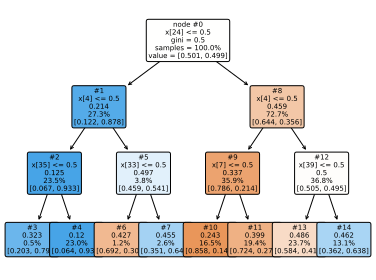

In [ ]:
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score


def decision_tree(X, criterion):
    dt = tree.DecisionTreeClassifier(max_depth=3, criterion=criterion, random_state=5483)
    dt.fit(X[0], train_y)

    pred_y = dt.predict(X[1])
    print(accuracy_score(test_y, pred_y))
    print(f1_score(test_y, pred_y, average="weighted"))

    options = {
        "label": "root",
        "filled": True,
        "node_ids": True,
        "proportion": True,
        "rounded": True,
        "fontsize": 7,
    }  # store options as dict for reuse


    plt.figsize=(18, 12)
    _ = tree.plot_tree(dt, **options)
decision_tree(feature_sets_all["One_hot_encoding"], "gini")

Here, we firstlt still use Naive Bayes as an example to find a suitable parameter.

In [17]:
parameters = {'alpha': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}

for name, dataset in feature_sets_all.items():

    print("Feature: " + name, end='')

    nb = naive_bayes.BernoulliNB()

    clf = GridSearchCV(nb, parameters, cv=5, scoring='roc_auc')

    clf.fit(dataset[0], train_y)

    print("     Best parameters set found on development set:" + str(clf.best_params_) , end='')


    y_true, y_pred = test_y, clf.predict(dataset[1])

    print("     Best AUC Score: ", roc_auc_score(y_true, y_pred))

Feature: One_hot_encoding     Best parameters set found on development set:{'alpha': 100}     Best AUC Score:  0.7330622622511918
Feature: word2vec_embedding     Best parameters set found on development set:{'alpha': 100}     Best AUC Score:  0.49783423459956044
Feature: Atchley_Factor_Mapping     Best parameters set found on development set:{'alpha': 0.01}     Best AUC Score:  0.719741148044978
Feature: Blosum_50_Mapping     Best parameters set found on development set:{'alpha': 1}     Best AUC Score:  0.723639402883284
Feature: Blosum_62_Mapping     Best parameters set found on development set:{'alpha': 0.1}     Best AUC Score:  0.7237399745172447


For different types of feature representations, we have searched for a suitable parameter that maximizes the AUC. For grid search, we used 5 fold cross-validation, where the model is trained 5 times, each time with a different subset of data as the validation set and the rest as the training set, to avoid overfitting of the data.

Next, we used a variety of machine learning methods including Support Vector Machines (with different kernels), Ada Boost Classifier, XGBoost Classifier, Random Forest, Gradient Boosting Classifier, Gradient Boosting Classifier, K Nearest Neighbors Classifier, and different parameter ranges for them. We present these classifiers and their corresponding clf in a dictionary.

Below is the function we have defined that will traverse these classifiers to generate the combination of parameters that maximizes the AUC value based on the given feature representation.

In [21]:
# setup all the parameters and models
exps = {
    'svm-lin': { 
        'paramgrid': {'C': logspace(-2,3,5)},
        'clf': svm.SVC(kernel='linear') },
    'svm-rbf': {
        'paramgrid': {'C': logspace(-2,3,5), 
                      'gamma': logspace(-4,3,5) },
        'clf': svm.SVC(kernel='rbf') },
    'svm-poly': {
        'paramgrid': {'C': logspace(-2,3,5), 
                      'degree': [2, 3, 4] },
        'clf': svm.SVC(kernel='poly') },   
    'ada': {
        'paramgrid': {'learning_rate': logspace(-6,0,5), 
                      'n_estimators': [5, 15, 25, 50, 100, 200, 500, 1000]},
        'clf': ensemble.AdaBoostClassifier(random_state=4487, algorithm = "SAMME" ) },
    'xgb': {
        'paramsampler': {    
            "gamma":            stats.uniform(0, 0.5),    # default=0
            "max_depth":        stats.randint(2, 6),      # default=6
            "subsample":        stats.uniform(0.6, 0.4),  # default=1
            "learning_rate":    stats.uniform(.001,1),    # default=1 (could also use loguniform)
            "n_estimators":     stats.randint(10, 1000),
         },
        'clf': xgb.XGBClassifier(objective="binary:logistic", eval_metric='logloss', 
                                 random_state=4487, use_label_encoder=False) },
    'rf': {
        'paramsampler':  {'max_features':      stats.uniform(0,0.5),
                          'max_depth':         stats.randint(1,10),
                          'n_estimators':      [5, 15, 25, 50, 100,200,500,1000]},
        'clf': ensemble.RandomForestClassifier(random_state=4487) },
    'gb': {
        'paramsampler':  {'learning_rate': logspace(-6,0,5),
                          'n_estimators':      [5, 15, 25, 50, 100,200,500,1000]},
        'clf': ensemble.GradientBoostingClassifier()
          },
    'knn': {
        'paramsampler':  { 'n_neighbors': [2, 3, 4, 5, 7,10]},
           'clf': neighbors.KNeighborsClassifier()
    }
}


def test_different_model(trainXfn, trainY, testXfn, testY, dataset_name, exps):
    aucs = {}
    clfs2 = {}
    for (name,ex) in exps.items():
        print("=== " + name + " ===")
        if name in clfs2:
            print("exists skipping")
        else:        
            if 'paramgrid' in ex:
                myclf = model_selection.GridSearchCV(ex['clf'], ex['paramgrid'], cv=5, verbose=0, n_jobs=4)
            else:
                myclf = model_selection.RandomizedSearchCV(ex['clf'], 
                                param_distributions=ex['paramsampler'], 
                                random_state=4487, n_iter=100, cv=5, 
                                verbose=0, n_jobs=4)

            myclf.fit(trainXfn, trainY)

            print("best params:", myclf.best_params_)

            clfs2[name] = myclf
    predYtrain = {}
    predYtest  = {}
    for (name,clf) in clfs2.items():
        predYtrain[name] = clf.predict(trainXfn)
        predYtest[name]  = clf.predict(testXfn)
        dump(clf, "./model_clf/" +dataset_name + name+'.joblib')

        # calculate accuracy
        # trainacc = metrics.accuracy_score(trainY, predYtrain[name])
        # testacc  = metrics.accuracy_score(testY, predYtest[name])
        auc = roc_auc_score(testY, predYtest[name])
        # trainaccs[name] = trainacc
        # testaccs[name] = testacc
        aucs[name] = auc
        print("{}: AUC={}".format(name, auc))
        
    return(name, aucs)

Next, we ran the above code and found these parameter combinations.

In [22]:
accuracy_result = {} 
for name, dataset in feature_sets_all.items():
    accuracy_result[name] = {
        "train_data" : dataset[0],
        "test_data"  : dataset[1],
        "scores" : {}
    }



for (dataset_name, data) in accuracy_result.items():
    print('-----------Feature: ', dataset_name,'------------')
    # if data["scores"] is None:
    model_name, aucs = test_different_model(
        data["train_data"][::100], 
        train_y[::100], 
        data["test_data"][::100], 
        test_y[::100], 
        dataset_name,
        exps)
    accuracy_result[dataset_name]["scores"].update(aucs)

-----------Feature:  One_hot_encoding ------------
=== svm-lin ===
best params: {'C': 0.1778279410038923}
=== svm-rbf ===
best params: {'C': 56.23413251903491, 'gamma': 0.005623413251903491}
=== svm-poly ===
best params: {'C': 0.1778279410038923, 'degree': 4}
=== ada ===
best params: {'learning_rate': 1.0, 'n_estimators': 25}
=== xgb ===
best params: {'gamma': 0.4748045377557148, 'learning_rate': 0.42405595509743976, 'max_depth': 3, 'n_estimators': 244, 'subsample': 0.8673579021672346}
=== rf ===
best params: {'max_depth': 6, 'max_features': 0.44847021943969706, 'n_estimators': 25}
=== gb ===
best params: {'n_estimators': 15, 'learning_rate': 1.0}
=== knn ===
best params: {'n_neighbors': 10}
svm-lin: AUC=0.72875
svm-rbf: AUC=0.72875
svm-poly: AUC=0.7279166666666668
ada: AUC=0.6566666666666667
xgb: AUC=0.7454166666666667
rf: AUC=0.6975
gb: AUC=0.7054166666666668
knn: AUC=0.7183333333333333
-----------Feature:  word2vec_embedding ------------
=== svm-lin ===
best params: {'C': 1000.0}
==

Let us check up the best parameters of different features.

In [23]:
for (dataset_name, data) in accuracy_result.items():
    print(dataset_name, accuracy_result[dataset_name]["scores"])

One_hot_encoding {'svm-lin': 0.72875, 'svm-rbf': 0.72875, 'svm-poly': 0.7279166666666668, 'ada': 0.6566666666666667, 'xgb': 0.7454166666666667, 'rf': 0.6975, 'gb': 0.7054166666666668, 'knn': 0.7183333333333333}
word2vec_embedding {'svm-lin': 0.7191666666666667, 'svm-rbf': 0.7783333333333333, 'svm-poly': 0.7183333333333333, 'ada': 0.7175, 'xgb': 0.7366666666666668, 'rf': 0.66625, 'gb': 0.7366666666666668, 'knn': 0.6791666666666666}
Atchley_Factor_Mapping {'svm-lin': 0.7462500000000001, 'svm-rbf': 0.7470833333333333, 'svm-poly': 0.7566666666666667, 'ada': 0.74, 'xgb': 0.7262500000000001, 'rf': 0.7879166666666667, 'gb': 0.775, 'knn': 0.6758333333333333}
Blosum_50_Mapping {'svm-lin': 0.7870833333333332, 'svm-rbf': 0.7870833333333332, 'svm-poly': 0.8191666666666668, 'ada': 0.7175, 'xgb': 0.7158333333333333, 'rf': 0.8087500000000001, 'gb': 0.7054166666666668, 'knn': 0.6670833333333334}
Blosum_62_Mapping {'svm-lin': 0.7470833333333333, 'svm-rbf': 0.7991666666666667, 'svm-poly': 0.7975, 'ada':

## Train the classifier using the optimal parameter set

Next, we used the previously obtained set of parameters to train our classifier. 

For the Kaggle competition, only **AUROC** was used as a basis for judging. Receiver Operating Characteristic (ROC) curves are generated by plotting True Positive Rate (TPR) and False Positive Rate (FPR) at different classification thresholds.

$$\text{TPR} = \frac{TP} {(TP + FN)}$$

$$\text{FPR} = \frac{FP} {(TP + FN)}$$

We believe that if we only refer to this one metric, i.e. AUROC value, it does not reflect the good or bad performance of the training.

Therefore, we refer to the confusion matrices, hoping to learn the True Positive, False Positive, True Negative, False Negative of the model after training and prediction, and to compute the other metrics through them as follows:

1. **Accuracy**: The proportion of all correctly predicted samples (both true and true negative examples) to the total number of samples. The formula is given below: $$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

2. **Precision**: The proportion of samples predicted to be positive cases that are truly positive cases. The formula is given below:$$\text{Precision} = \frac{TP}{TP + FP}$$

3. **Sensitivity(TPR)**: The proportion of true positive case samples to all samples that are actually positive cases. The formula is given below: $$\text{Sensitivity} = \frac{TP}{TP + FN}$$

4. **Specificity**: The proportion of true counterexample samples to all samples that are actually counterexamples. The formula is given below: $$\text{Specificity} = \frac{TN}{TN + FP}$$

5. **F1 Score**: The reconciled average of precision and recall for cases where both precision and recall are considered. The formula is given below: $$\text{F1\ Score} = 2 \times \frac{Precision \times Sensitivity}{Precision + Sensitivity}$$


Here, we define a function that defines a classifier based on the parameters and calculates all the above metrics based on the test set and plots the ROC curve.

In [32]:

def train_and_predict_all_features(feature_sets, trainY, testY, clf, params, clf_name):
    
    if params is not None:
        clf = clf.set_params(**params)

    metrics_data = []
    plt.figure()
    testY = testY[::]
    trainY = trainY[::]

    for name, dataset in feature_sets.items():
        print("Training started. Feature set:",name)
        trainX = dataset[0][::]
        testX = dataset[1][::]

        # Training and Predicting
        clf.fit(trainX,trainY)

        print("Predicting started. Feature set:",name)
        predY = clf.predict(testX)
        predY_proba = clf.predict_proba(testX)

        # Calculate metrics data
        accuracy = accuracy_score(testY, predY)
        auc = roc_auc_score(testY, predY_proba[:, 1])
        f1 = f1_score(testY, predY)
        precision = precision_score(testY, predY)



        tn, fp, fn, tp = confusion_matrix(testY, predY).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        metrics_data.append([name, accuracy, auc, f1, precision, sensitivity, specificity])

        # Show metrics data
        print(f"Result for feature set: {name}")
        print("    Accuracy: ", accuracy)
        print("    AUC: ", auc)
        print("    F1 Score: ", f1)
        print("    Precision: ", precision)
        print("    Sensitivity: ", sensitivity)
        print("    Specificity: ", specificity)

        # Draw ROC Curve
        # print(testY)
        # print(predY)
        fpr, tpr, _ = roc_curve(testY, predY_proba[:, 1])
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic ['+clf_name+']')
    plt.legend(loc="lower right")
    plt.show()

    # Create a DataFrame to store the metrics data
    df = pd.DataFrame(metrics_data, columns=['name', 'accuracy', 'auc', 'f1', 'precision', 'sensitivity', 'specificity'])

    # Plot the radar chart
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    metrics = df.columns[1:]  # Exclude the 'name' column
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    ax.set_thetagrids(np.degrees(angles), metrics, fontsize = 14)
    angles += angles[:1]  # To make the plot circular

    for i, row in df.iterrows():
        values = row[metrics].values.flatten().tolist()
        values += values[:1]  # To make the plot circular
        ax.plot(angles, values, label=row['name'], lw=1.75)

    ax.set_title('Comparison of metrics [' + clf_name + ']', size=16)
    ax.legend(loc='lower right', bbox_to_anchor=(1.3, -0.1), prop={'size': 13})
    plt.show()
    return None

First, we run Bernoullli Naive Bayes to see how it performs.

Training started. Feature set: One_hot_encoding
Predicting started. Feature set: One_hot_encoding
Result for feature set: One_hot_encoding
    Accuracy:  0.7318830539005127
    AUC:  0.7839470929460077
    F1 Score:  0.6826308020337872
    Precision:  0.8452477660438668
    Sensitivity:  0.5724896836313618
    Specificity:  0.8936348408710217
Training started. Feature set: word2vec_embedding
Predicting started. Feature set: word2vec_embedding
Result for feature set: word2vec_embedding
    Accuracy:  0.4993764722183733
    AUC:  0.49760198670257905
    F1 Score:  0.5875099897248544
    Precision:  0.5021467603434816
    Sensitivity:  0.7078404401650619
    Specificity:  0.2878280290340592
Training started. Feature set: Atchley_Factor_Mapping
Predicting started. Feature set: Atchley_Factor_Mapping
Result for feature set: Atchley_Factor_Mapping
    Accuracy:  0.7183040044339754
    AUC:  0.7686449210748839
    F1 Score:  0.699215860334369
    Precision:  0.7564020486555698
    Sensitivity

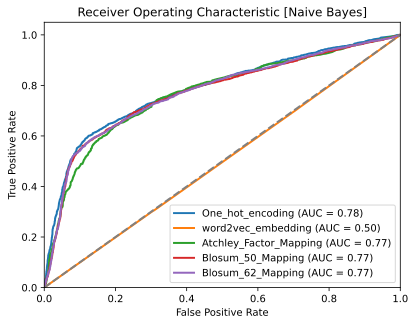

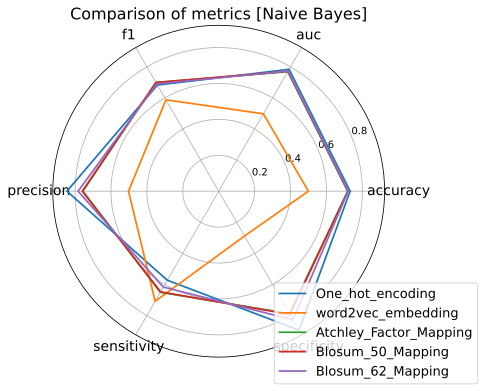

In [ ]:
# Bernoulli NB
train_and_predict_all_features(feature_sets_all, 
                               train_y, 
                               test_y, 
                               naive_bayes.BernoulliNB(alpha=100), 
                               None,
                               "Naive Bayes")

We can see that different feature representations have a significant impact on Bernoulli Naive Bayes. This may be because the performance of Naive Bayes is affected by the assumption of feature independence and also by feature sparsity.

In addition, the orange line perform the worst, which may be due to the fact that word2vec loses many data.

Next, see how the random forest behaves.

Training started. Feature set: One_hot_encoding
Predicting started. Feature set: One_hot_encoding
Result for feature set: One_hot_encoding
    Accuracy:  0.7831508937231537
    AUC:  0.8576764304481295
    F1 Score:  0.764484574868322
    Precision:  0.8438538205980066
    Sensitivity:  0.6987620357634112
    Specificity:  0.868788386376326
Training started. Feature set: word2vec_embedding
Predicting started. Feature set: word2vec_embedding
Result for feature set: word2vec_embedding
    Accuracy:  0.7780241097408895
    AUC:  0.8476200734683658
    F1 Score:  0.7556436851738866
    Precision:  0.8479972612119138
    Sensitivity:  0.6814305364511691
    Specificity:  0.8760469011725294
Training started. Feature set: Atchley_Factor_Mapping
Predicting started. Feature set: Atchley_Factor_Mapping
Result for feature set: Atchley_Factor_Mapping
    Accuracy:  0.824719412498268
    AUC:  0.8916985201108707
    F1 Score:  0.8094592559120349
    Precision:  0.894474034620506
    Sensitivity:  0

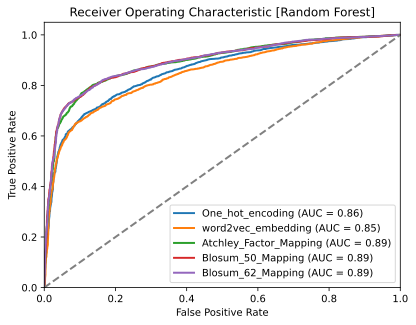

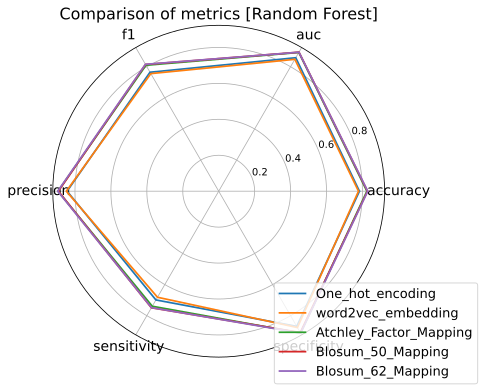

In [ ]:
# Random Forest
train_and_predict_all_features(feature_sets_all, 
                               train_y, 
                               test_y, 
                               ensemble.RandomForestClassifier(random_state=4487), 
                               {'max_depth': 9, 'max_features': 0.06726827102785993, 'n_estimators': 100},
                               "Random Forest")

Here, the gap between the performance of the different features is not as large as in Naive Bayes, but it can still be seen that the feature of word2vec perform worse.

What about other classifiers?

Training started. Feature set: One_hot_encoding
Predicting started. Feature set: One_hot_encoding
Result for feature set: One_hot_encoding
    Accuracy:  0.7331301094637661
    AUC:  0.8085545794078138
    F1 Score:  0.6740013540961408
    Precision:  0.8759348878134624
    Sensitivity:  0.5477303988995873
    Specificity:  0.9212730318257957
Training started. Feature set: word2vec_embedding
Predicting started. Feature set: word2vec_embedding
Result for feature set: word2vec_embedding
    Accuracy:  0.6987668006096716
    AUC:  0.7646439057583501
    F1 Score:  0.6489018087855297
    Precision:  0.7856863511928041
    Sensitivity:  0.5526822558459422
    Specificity:  0.8470128419877163
Training started. Feature set: Atchley_Factor_Mapping
Predicting started. Feature set: Atchley_Factor_Mapping
Result for feature set: Atchley_Factor_Mapping
    Accuracy:  0.7540529305805737
    AUC:  0.8204965681225939
    F1 Score:  0.7256992736825839
    Precision:  0.8279266572637518
    Sensitivity

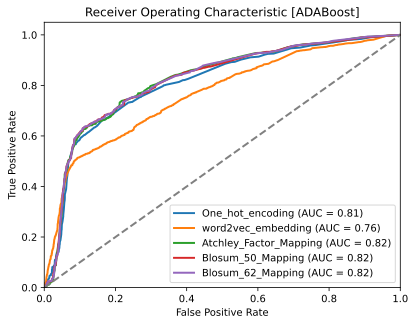

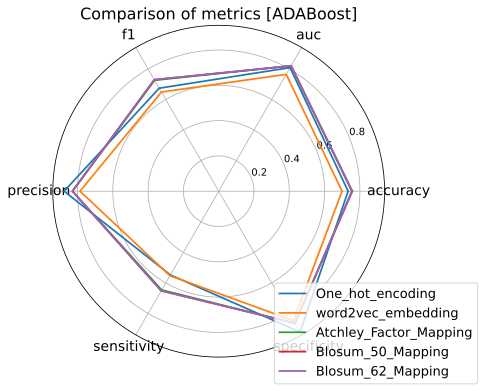

In [ ]:
# Ada Boost
train_and_predict_all_features(feature_sets_all, 
                               train_y, 
                               test_y, 
                               ensemble.AdaBoostClassifier(random_state=4487), 
                               {'learning_rate': 0.03162277660168379, 'n_estimators': 200},
                               "ADABoost")

Training started. Feature set: One_hot_encoding
Predicting started. Feature set: One_hot_encoding
Result for feature set: One_hot_encoding
    Accuracy:  0.7902175419149231
    AUC:  0.8609989808433886
    F1 Score:  0.7810240092565809
    Precision:  0.8234217749313815
    Sensitivity:  0.7427785419532325
    Specificity:  0.838358458961474
Training started. Feature set: word2vec_embedding
Predicting started. Feature set: word2vec_embedding
Result for feature set: word2vec_embedding
    Accuracy:  0.780379659138146
    AUC:  0.8477216819232953
    F1 Score:  0.7699898418226673
    Precision:  0.8148034398034398
    Sensitivity:  0.7298486932599725
    Specificity:  0.8316582914572864
Training started. Feature set: Atchley_Factor_Mapping
Predicting started. Feature set: Atchley_Factor_Mapping
Result for feature set: Atchley_Factor_Mapping
    Accuracy:  0.841485381737564
    AUC:  0.8962647948592113
    F1 Score:  0.8363376251788269
    Precision:  0.8712369597615499
    Sensitivity:  

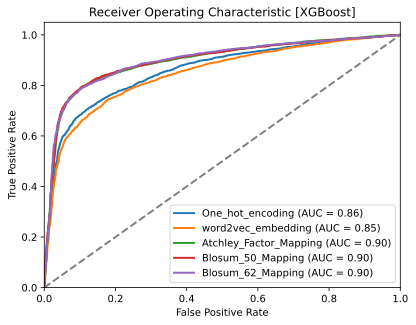

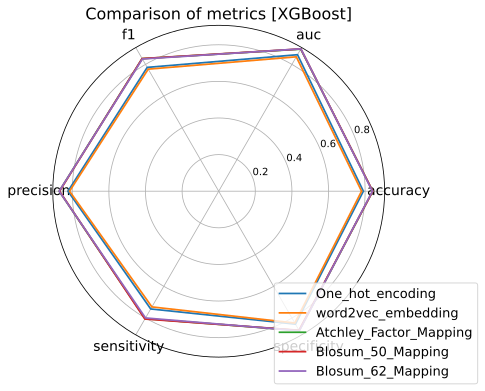

In [ ]:
# XGBoost
train_and_predict_all_features(feature_sets_all, 
                               train_y, 
                               test_y, 
                               xgb.XGBClassifier(objective="binary:logistic", eval_metric='logloss', random_state=4487, use_label_encoder=False), 
                               {'gamma': 0.4748045377557148, 'learning_rate': 0.42405595509743976, 'max_depth': 3, 'n_estimators': 244, 'subsample': 0.8673579021672346},
                               "XGBoost")

Training started. Feature set: One_hot_encoding
Predicting started. Feature set: One_hot_encoding
Result for feature set: One_hot_encoding
    Accuracy:  0.7845365110156575
    AUC:  0.8583234067325778
    F1 Score:  0.7751265365148229
    Precision:  0.8170731707317073
    Sensitivity:  0.7372764786795049
    Specificity:  0.8324958123953099
Training started. Feature set: word2vec_embedding
Predicting started. Feature set: word2vec_embedding
Result for feature set: word2vec_embedding
    Accuracy:  0.7582097824580851
    AUC:  0.827582394626349
    F1 Score:  0.7480144404332131
    Precision:  0.7872340425531915
    Sensitivity:  0.7125171939477304
    Specificity:  0.8045784477945283
Training started. Feature set: Atchley_Factor_Mapping
Predicting started. Feature set: Atchley_Factor_Mapping
Result for feature set: Atchley_Factor_Mapping
    Accuracy:  0.8266592767077733
    AUC:  0.8824419745064924
    F1 Score:  0.8205422464495769
    Precision:  0.8573141486810552
    Sensitivity:

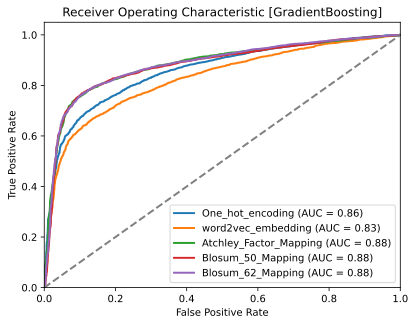

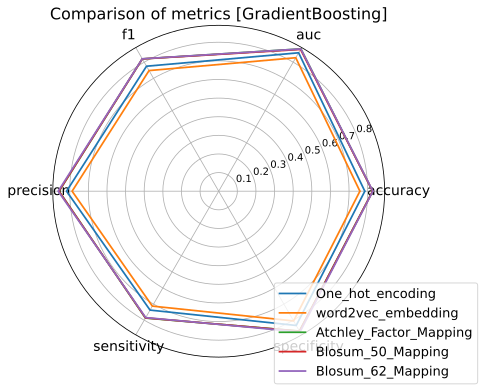

In [ ]:
# Gradient Boosting
train_and_predict_all_features(feature_sets_all, 
                               train_y, 
                               test_y, 
                               ensemble.GradientBoostingClassifier(), 
                               {'n_estimators': 50, 'learning_rate': 1.0},
                               "GradientBoosting")

Training started. Feature set: One_hot_encoding
Predicting started. Feature set: One_hot_encoding
Result for feature set: One_hot_encoding
    Accuracy:  0.796729943189691
    AUC:  0.8579290307567181
    F1 Score:  0.7811427718931822
    Precision:  0.8533246414602347
    Sensitivity:  0.7202200825309492
    Specificity:  0.8743718592964824
Training started. Feature set: word2vec_embedding
Predicting started. Feature set: word2vec_embedding
Result for feature set: word2vec_embedding
    Accuracy:  0.8001939864209505
    AUC:  0.863509854023288
    F1 Score:  0.7862436999703528
    Precision:  0.8524590163934426
    Sensitivity:  0.7295735900962861
    Specificity:  0.871859296482412
Training started. Feature set: Atchley_Factor_Mapping
Predicting started. Feature set: Atchley_Factor_Mapping
Result for feature set: Atchley_Factor_Mapping
    Accuracy:  0.8452265484273244
    AUC:  0.9018177007611803
    F1 Score:  0.8378103673587919
    Precision:  0.8871463714637147
    Sensitivity:  

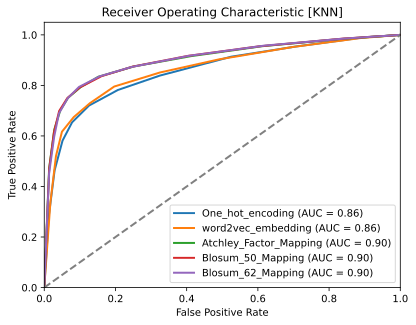

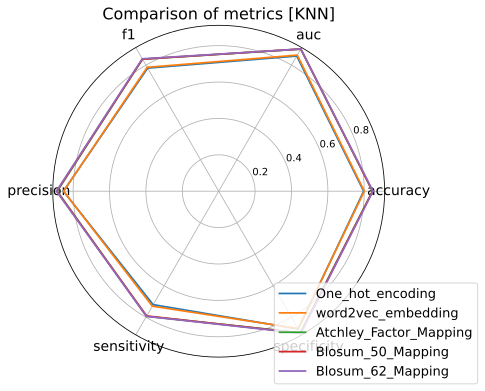

In [ ]:
# KNN
train_and_predict_all_features(feature_sets_all, 
                               train_y, 
                               test_y, 
                               neighbors.KNeighborsClassifier(), 
                               {'n_neighbors': 10},
                               "KNN")

Collectively, Blosum 50 Mapping and Blosum 62 Mapping outperform the other features in terms of performance.

For some features, they have high Precision and low Sensitivity. This means that the model has a low error rate in predicting positive examples, however, the model did not manage to detect most of the true examples, i.e., the model may predict many samples that are actually positive as negative examples.

### Voting Classifier

Since we already have so many tuned parameterized classifiers, we might as well try a voting classifier. In this way, we can combine multiple models and balance the strengths and weaknesses of each to improve overall predictive performance.

Here, we have mainly used soft voting because we need the final output to be a probability value rather than a binary label.

We start by integrating these classifiers and associated parameters.

In [ ]:
clf_rf = ensemble.RandomForestClassifier(random_state=4487,max_depth=9,max_features=0.06726827102785993,n_estimators=100)

clf_ada = ensemble.AdaBoostClassifier(random_state=4487,learning_rate=0.03162277660168379, n_estimators=200)

clf_xbg = xgb.XGBClassifier(objective="binary:logistic", eval_metric='logloss', random_state=4487, use_label_encoder=False,gamma= 0.4748045377557148, learning_rate= 0.42405595509743976, max_depth= 3, n_estimators= 244, subsample= 0.8673579021672346)

clf_gb = ensemble.GradientBoostingClassifier(n_estimators= 50, learning_rate = 1.0)

clf_knn = neighbors.KNeighborsClassifier(n_neighbors= 10)

clf_svm_poly = svm.SVC(C= 0.1778279410038923, degree= 4, kernel='poly',probability=True)

clf_svm_rbf = svm.SVC(C= 3.1622776601683795, gamma = 0.005623413251903491, kernel='rbf',probability=True)

clf_nb = naive_bayes.BernoulliNB(alpha = 100)

We combined them and added the voting classifier.

In [ ]:
clf_list = [
    ('rf', clf_rf), 
    ('ada', clf_ada), 
    ('xgb', clf_xbg), 
    ('gc', clf_gb), 
    ('knn', clf_knn), 
    ('svm_poly', clf_svm_poly), 
    ('svm_rbf', clf_svm_rbf), 
    ('nb', clf_nb)
]

voting_clf = ensemble.VotingClassifier(estimators=clf_list, voting='soft')

Training started. Feature set: One_hot_encoding
Predicting started. Feature set: One_hot_encoding
Result for feature set: One_hot_encoding
    Accuracy:  0.7921574061244284
    AUC:  0.8618031315065316
    F1 Score:  0.7773820124666073
    Precision:  0.8440219142765066
    Sensitivity:  0.7204951856946354
    Specificity:  0.8648799553322166
Training started. Feature set: word2vec_embedding
Predicting started. Feature set: word2vec_embedding
Result for feature set: word2vec_embedding
    Accuracy:  0.7893861715394208
    AUC:  0.8575233265517562
    F1 Score:  0.7734048896839595
    Precision:  0.844126260982753
    Sensitivity:  0.713617606602476
    Specificity:  0.8662758235622557
Training started. Feature set: Atchley_Factor_Mapping
Predicting started. Feature set: Atchley_Factor_Mapping
Result for feature set: Atchley_Factor_Mapping
    Accuracy:  0.8370514064015518
    AUC:  0.8962621452056245
    F1 Score:  0.8264974918855119
    Precision:  0.8911867642379891
    Sensitivity: 

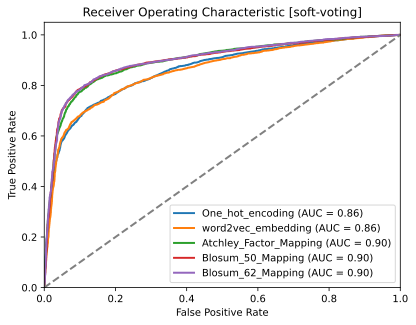

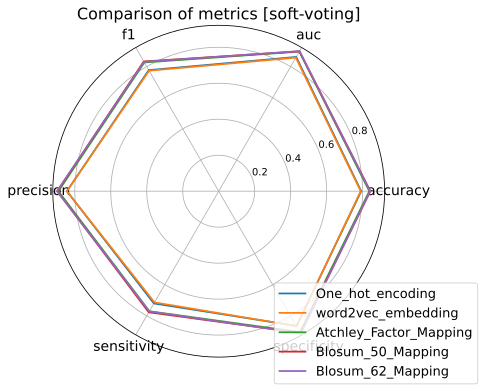

In [ ]:
train_and_predict_all_features(feature_sets_all, 
                               train_y, 
                               test_y, 
                               voting_clf, 
                               None,
                               "soft-voting")

Here are our result of AUROCs:

|                       | One-hot | WordsVec | Atchley | Blosum50 | Blosum62 |
| --------------------- | ------- | -------- | ------- | -------- | -------- |
| Bernoulli Naive Bayes | 0.78    | 0.50     | 0.77    | 0.77     | 0.77     |
| Random Forest         | 0.86    | 0.85     | 0.89    | 0.89     | 0.89     |
| ADABoost              | 0.81    | 0.76     | 0.82    | 0.82     | 0.82     |
| XGBoost               | 0.86    | 0.85     | 0.90    | 0.90     | 0.90     |
| Gradient Boosting     | 0.86    | 0.83     | 0.88    | 0.88     | 0.88     |
| KNN                   | 0.86    | 0.86     | 0.90    | 0.90     | 0.90     |
| Soft-Voting           | 0.86    | 0.86     | 0.90    | 0.90     | 0.90     |
